Reference paper (not my work) - https://arxiv.org/abs/1901.11103
RNN to learn the potential to density mapping

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
potentials_dict = np.load('./Potentials.npz')
densities_dict = np.load('./Densities.npz')

In [3]:
potentials = potentials_dict['arr_0']
densities = densities_dict['arr_0']

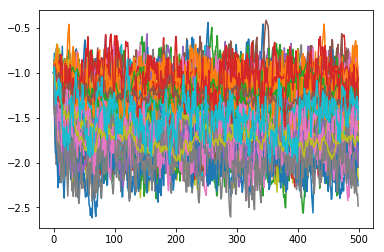

In [4]:
for i in range(len(potentials)):
    plt.plot(potentials[i])

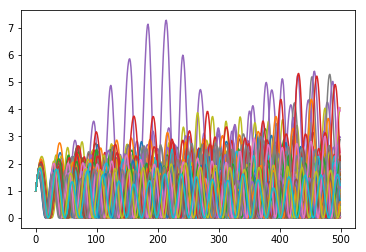

In [5]:
for i in range(len(densities)):
    plt.plot(densities[i])

In [6]:
class IntroRNN(nn.Module):
    
    def __init__(self, n_steps, order, hidden_dim):
        super(IntroRNN, self).__init__()
        self.nw = order
        self.d = hidden_dim
        W = torch.zeros(self.nw, self.d, self.d)
        W[0] = torch.ones(self.d, self.d) + (1/self.d) * 0.01 * torch.randn(self.d, self.d)
        for i in range(1, self.nw):
            W[i] = (1/self.d) * 0.01 * torch.randn(self.d, self.d)
        self.W = nn.Parameter(W.clone())
        self.register_buffer('h', torch.ones(self.d))
#         self.h = nn.Parameter(torch.ones(self.d), requires_grad=False)
        p = torch.zeros(self.d)
        p[0] = 1
        self.p = nn.Parameter(p.clone())
        self.T = n_steps

    def forward(self, x):
        assert x.shape == torch.Size([self.T, 1])
        x = torch.squeeze(x)
        out = torch.zeros(self.T)
        for i in range(self.T):
            coeffs = torch.stack([self.W[j]*(x[i]**j) for j in range(self.nw)])
            self.h = torch.mv(coeffs.sum(dim = 0), self.h)
            out[i] = torch.dot(self.p, self.h)
        return out
    
    def init_hidden(self):
        self.h = torch.ones(self.d).cuda()        

In [7]:
n_steps = 25
order = 2
hidden_dim = 4
rnn = IntroRNN(n_steps, order, hidden_dim)
list(rnn.parameters())

[Parameter containing:
 tensor([[[ 9.9931e-01,  1.0026e+00,  9.9617e-01,  9.9691e-01],
          [ 1.0011e+00,  1.0025e+00,  1.0016e+00,  9.9925e-01],
          [ 9.9905e-01,  1.0023e+00,  1.0019e+00,  9.9810e-01],
          [ 9.9947e-01,  1.0010e+00,  9.9871e-01,  9.9992e-01]],
 
         [[ 3.4735e-03, -4.3338e-04,  1.2128e-03,  8.4023e-04],
          [-1.9200e-03, -2.4061e-03, -3.6596e-03,  3.6115e-03],
          [-5.9436e-04,  2.6326e-04, -1.0586e-03,  2.0035e-03],
          [ 4.3661e-03,  2.3642e-03, -2.6206e-03,  3.2716e-03]]],
        requires_grad=True), Parameter containing:
 tensor([1., 0., 0., 0.], requires_grad=True)]

In [8]:
x = torch.tensor(potentials[0][:n_steps], dtype = torch.float)
y = torch.tensor(densities[0][:n_steps], dtype = torch.float)

In [9]:
criterion = nn.MSELoss()
out = rnn(torch.unsqueeze(torch.as_tensor(x), dim = 1))
loss = criterion(out, y)
print(loss)
rnn.zero_grad()
loss.backward()
print(rnn.W.grad)
print(rnn.p.grad)

tensor(5.2097e+28, grad_fn=<MseLossBackward>)
tensor([[[ 1.8151e+29,  1.8243e+29,  1.8203e+29,  1.8157e+29],
         [ 1.5610e+29,  1.5688e+29,  1.5655e+29,  1.5615e+29],
         [ 1.5594e+29,  1.5672e+29,  1.5639e+29,  1.5599e+29],
         [ 1.5508e+29,  1.5585e+29,  1.5552e+29,  1.5513e+29]],

        [[-2.2168e+29, -2.2281e+29, -2.2232e+29, -2.2175e+29],
         [-1.8794e+29, -1.8889e+29, -1.8848e+29, -1.8800e+29],
         [-1.8775e+29, -1.8870e+29, -1.8829e+29, -1.8781e+29],
         [-1.8670e+29, -1.8764e+29, -1.8724e+29, -1.8676e+29]]])
tensor([1.0419e+29, 1.0477e+29, 1.0452e+29, 1.0422e+29])


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cuda', index=0)

In [12]:
n_seq = len(potentials)
seq_len = len(potentials[0])
n_train = int(0.7*n_seq)

In [13]:
X_train = np.array([potentials[i][j*n_steps:(j + 1)*n_steps] for i in range(n_train) for j in range(seq_len//n_steps)])
X_train.shape

(1400, 25)

In [14]:
y_train = np.array([densities[i][j*n_steps:(j + 1)*n_steps] for i in range(n_train) for j in range(seq_len//n_steps)])
y_train.shape

(1400, 25)

In [15]:
Xy = np.hstack((X_train, y_train))
print(Xy.shape)
np.random.shuffle(Xy)
X_train = Xy[:, :X_train.shape[1]]
y_train = Xy[:, X_train.shape[1]:]

(1400, 50)


In [16]:
X_train.shape

(1400, 25)

In [17]:
y_train.shape

(1400, 25)

In [18]:
model = IntroRNN(n_steps, order, hidden_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.MSELoss()
loss_vals = []

In [19]:
epochs = 5
for e in range(epochs):
    print('Epoch = {}, loss = {}'.format(e, avg_loss))
    avg_loss = 0
    for i in range(len(X_train)):
#         if i % 10 == 0:
#             continue
        data = torch.unsqueeze(torch.as_tensor(X_train[i], dtype = torch.float), dim = 1)
        data = data.to(device)
        target = torch.unsqueeze(torch.as_tensor(y_train[i], dtype = torch.float), dim = 1)
#         target = target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss_vals.append(loss.item())
        avg_loss += loss_vals[-1]
        loss.backward(retain_graph = True)
        optimizer.step()
        model.init_hidden()
    avg_loss /= len(X_train)

Epoch = 0
Epoch = 1
Epoch = 2
Epoch = 3
Epoch = 4


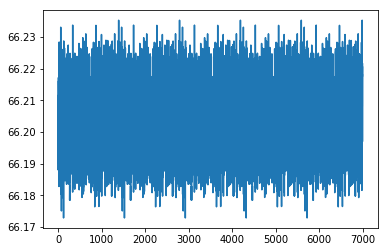

In [20]:
plt.plot(np.log(np.array(loss_vals)))

In [21]:
loss_vals[-10:-1]

[5.687894922644097e+28,
 5.82914043191008e+28,
 5.761717316687557e+28,
 5.673111554369473e+28,
 5.731098436885926e+28,
 5.726475240099197e+28,
 5.75056261481837e+28,
 5.610264412268851e+28,
 5.716857196283536e+28]

In [22]:
out

tensor([3.9975e+00, 1.6012e+01, 6.4133e+01, 2.5687e+02, 1.0289e+03, 4.1210e+03,
        1.6505e+04, 6.6106e+04, 2.6476e+05, 1.0604e+06, 4.2474e+06, 1.7012e+07,
        6.8139e+07, 2.7291e+08, 1.0930e+09, 4.3776e+09, 1.7533e+10, 7.0217e+10,
        2.8120e+11, 1.1262e+12, 4.5104e+12, 1.8065e+13, 7.2347e+13, 2.8974e+14,
        1.1603e+15], grad_fn=<CopySlices>)

In [23]:
target

tensor([[1.6272e+00],
        [1.6414e+00],
        [1.5936e+00],
        [1.4878e+00],
        [1.3323e+00],
        [1.1385e+00],
        [9.2156e-01],
        [6.9786e-01],
        [4.8367e-01],
        [2.9456e-01],
        [1.4428e-01],
        [4.4002e-02],
        [1.2789e-03],
        [1.9296e-02],
        [9.6774e-02],
        [2.2809e-01],
        [4.0372e-01],
        [6.1136e-01],
        [8.3693e-01],
        [1.0647e+00],
        [1.2775e+00],
        [1.4596e+00],
        [1.5991e+00],
        [1.6870e+00],
        [1.7178e+00]])

In [24]:
y = densities[-1]
X_test = [potentials[-1][j*batch_size:(j + 1)*batch_size] for j in range(seq_len//batch_size)]
yh = []
for i in range(len(X_test)):
    data = torch.unsqueeze(torch.as_tensor(X_test[i], dtype = torch.float), dim = 1)
    data = data.to(device)
    out = model(data)
    yh.extend(out.detach().numpy())
    model.init_hidden()

NameError: name 'batch_size' is not defined

In [ ]:
plt.figure()
plt.plot(y)
plt.plot(np.array(yh))

In [ ]:
model.W

In [ ]:
model.p